In [1]:
#importing the modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
#import plotly.express as px
from sklearn.neighbors import KNeighborsClassifier
plt.rc('font', size=20) 
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20) 
plt.rc('legend', fontsize=20)    
plt.rc('figure', titlesize=20)
import warnings
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False


#describing the columns and reading the data from the csv file
col_names = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins",
    "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root",
    "num_file_creations", "num_shells", "num_access_files",
    "num_outbound_cmds", "is_host_login", "is_guest_login", "count",
    "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate",
    "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate",
    "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate",
    "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
    "dst_host_srv_serror_rate", "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate", "labels"
]
df = pd.read_csv('../project/nsl-kdd/KDDTrain+.txt', names=col_names, index_col=False)


#exploring the dataset
df.head()
df.describe()
#labelling data as attack type and normal type and counting their values in the dataset
df.loc[df.labels != 'normal', 'labels'] = 'attack'
df['labels'].value_counts()

#exploring the dataset some more
print(f"Dataset shape:{df.shape}")
df.isna().sum()

#printing duplicate values and droping the columns with duplicate values
print(f"The number of duplicated records: {df.duplicated().sum()}")
df.drop_duplicates(inplace=True)

#splitting the data
X = df.drop('labels',axis=1)
Y = df['labels']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=41)
print(f"Train-set shape:{X_train.shape}")
print(f"Test-set shape:{X_test.shape}")

#exploring the training data
X_train.head()

#Scaling numeric features using Standard scalar
std_scaler = preprocessing.StandardScaler()
def standardization(df, col):
    for i in col:
        arr = np.array(df[i])
        df[i] = std_scaler.fit_transform(arr.reshape(len(arr),1))
    return df
  
numeric_col = X_train.select_dtypes(include='number').columns
X_train = standardization(X_train, numeric_col)
X_test = standardization(X_test, numeric_col)
X_train.head()

cat_col = X_train.select_dtypes('object').columns
# encoding train set
categorical_train = X_train[cat_col]
categorical_train = pd.get_dummies(categorical_train,columns=cat_col)
categorical_train.head()

X_train.drop(cat_col, axis=1, inplace=True)
X_train = pd.concat([X_train, categorical_train],axis=1)
X_train.head()


cat_col = X_test.select_dtypes('object').columns
# encoding test set
categorical_test = X_test[cat_col]
categorical_test = pd.get_dummies(categorical_test,columns=cat_col)

#Adding missing columns to the test set
fill_list = np.setdiff1d(categorical_train.columns, categorical_test.columns)
for item in fill_list:
    categorical_test[item]=0
categorical_test = categorical_test[categorical_train.columns]

#Combinig the features
X_test.drop(cat_col, axis=1, inplace=True)
X_test = pd.concat([X_test, categorical_test],axis=1)
X_test.head()

#dimensionality reduction using PCA
from sklearn.decomposition import PCA
pca = PCA(n_components= 0.99, random_state=40).fit(X_train)
print(f"The data has been reduced from {X_train.shape[1]} features to -> {len(pca.components_)} features")
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

#Feature selection using RFE (Recursive Feature Elimination)
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFECV
model = DecisionTreeClassifier()
rfe = RFECV(model, n_jobs=-1)
rfe.fit(X_train, Y_train)
new_features_count = len(rfe.estimator_.feature_importances_)
print(f"The number of features has been reduced from {X_train.shape[1]} to -> {new_features_count}")

X_train = rfe.transform(X_train)
X_test = rfe.transform(X_test)

Dataset shape:(125973, 42)
The number of duplicated records: 9
Train-set shape:(94473, 41)
Test-set shape:(31491, 41)
The data has been reduced from 122 features to -> 37 features
The number of features has been reduced from 37 to -> 27


In [2]:
from sklearn.neighbors import KNeighborsClassifier


test_scores = []
train_scores = []

for i in range(1,15):

    knn = KNeighborsClassifier(i)
    knn.fit(X_train,Y_train)
    
    train_scores.append(knn.score(X_train,Y_train))
    test_scores.append(knn.score(X_test,Y_test))

In [3]:
max_train_score = max(train_scores)
train_scores_ind = [i for i, v in enumerate(train_scores) if v == max_train_score]
print('Max train score {} % and k = {}'.format(max_train_score*100,list(map(lambda x: x+1, train_scores_ind))))

Max train score 99.99682448953669 % and k = [1]


In [4]:
max_test_score = max(test_scores)
test_scores_ind = [i for i, v in enumerate(test_scores) if v == max_test_score]
print('Max test score {} % and k = {}'.format(max_test_score*100,list(map(lambda x: x+1, test_scores_ind))))


Max test score 99.47286526309104 % and k = [1]


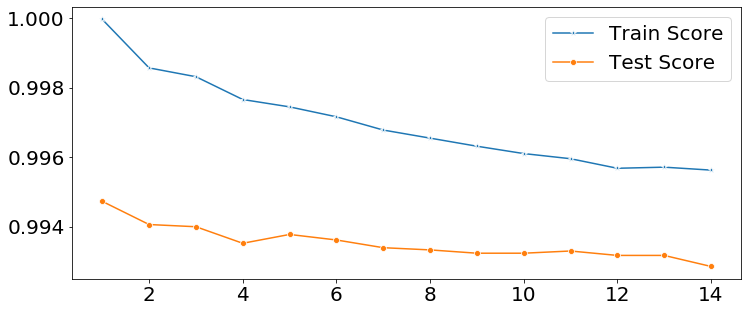

In [5]:
plt.figure(figsize=(12,5))
p = sns.lineplot(range(1,15),train_scores,marker='*',label='Train Score')
p = sns.lineplot(range(1,15),test_scores,marker='o',label='Test Score')

In [6]:
knn = KNeighborsClassifier(1)

knn.fit(X_train,Y_train)
knn.score(X_test,Y_test)

0.9947286526309104

In [7]:
from sklearn.metrics import confusion_matrix
#let us get the predictions using the classifier we had fit above
y_pred = knn.predict(X_test)
confusion_matrix(Y_test,y_pred)
pd.crosstab(Y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,attack,normal,All
True,,,
attack,14486,83,14569
normal,83,16839,16922
All,14569,16922,31491


Text(0.5, 6.0, 'Predicted label')

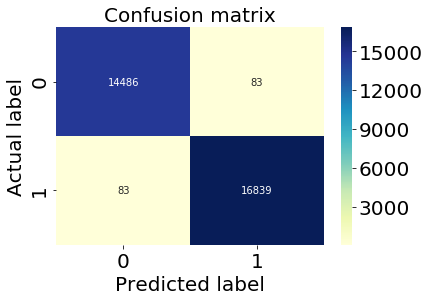

In [8]:
y_pred = knn.predict(X_test)
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(Y_test, y_pred)
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', Y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [9]:
from sklearn.metrics import classification_report
print(classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

      attack       0.99      0.99      0.99     14569
      normal       1.00      1.00      1.00     16922

    accuracy                           0.99     31491
   macro avg       0.99      0.99      0.99     31491
weighted avg       0.99      0.99      0.99     31491

